### Random Forest Regression auf dem Ames Housing Price Data Set

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. 

#### Versionsgeschichte

- 1.0 21.10.2023 Willi Hahn Initialversion
- 1.4 21.07.2024 Willi Hahn     
- 1.5 13.08.2024 Willi Hahn update fixes für Bokeh
- 1.6 23.07.2025 Willi Hahn Anpassung Pfade auf github, Logging mit Datendatei erweitert.


In [1]:
# notwendige Bibliotheken importieren und konfigurieren 
import os
import numpy as np
import pandas as pd
_ = pd.set_option('display.max_columns', None) # damit mehr als 20 Spalten angezeigt werden.
#                                                    _ =  damit Objektausgabe unterdrückt wird.
pd.set_option('display.min_rows', 15) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
pd.set_option('display.max_rows', 500) # damit nicht nur 10 Zeilen mit  ... dazwischen ausgegeben werden
import matplotlib.pyplot as plt #Plot Bibliothek
import seaborn as sns #importing Seaborn's for plots
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn import tree # Ausgabe des Entscheidungsbaums
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from timeit import default_timer as timer
import graphviz

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool
output_notebook(resources=None, verbose=True, hide_banner=True)

scriptname='Ames Random Forest.ipynb'
logtext=""
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    force=True,
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    filemode='a',
    filename="AllScripts.log" # Default ist append
)
logger = logging.getLogger()



In [2]:

# Daten einlesen
path = 'c:/myBox/Projekte/python/Ames_Cleaned_26_v1.csv'# für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/Ames_Cleaned_26_v1.csv'
df = pd.read_csv(path, sep=',') 

df.info(verbose=True, show_counts=True)

# Originaldaten einlesen für Unersuchungen der Vorhersagen
path = 'c:/myBox/Projekte/python/AmesHousing.csv' # für lokale Dateien
datendateiname=path
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/AmesHousing.csv'
df_org= pd.read_csv(path, sep=',') 

df_org.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2690 entries, 0 to 2689
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SalePrice            2690 non-null   int64  
 1   Order                2690 non-null   int64  
 2   Bsmt Qual            2690 non-null   float64
 3   Exter Qual           2690 non-null   int64  
 4   Fireplace Qu         2690 non-null   float64
 5   Functional           2690 non-null   int64  
 6   Garage Area          2690 non-null   int64  
 7   Garage Qual          2690 non-null   float64
 8   Gr Liv Area          2690 non-null   int64  
 9   HouseAge             2690 non-null   int64  
 10  TotalPorchSF         2690 non-null   int64  
 11  Kitchen Qual         2690 non-null   int64  
 12  Land Contour         2690 non-null   int64  
 13  Lot Area             2690 non-null   int64  
 14  Lot Frontage         2690 non-null   float64
 15  Lot Shape            2690 non-null   i

In [3]:
# Trainings- und Testdaten aufteilen
TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
RANDOM_STATE=42
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
#x.head().T
#y.head().T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=RANDOM_STATE)
dfx_test = pd.DataFrame(data=x_test, columns=x.columns) # Hilfe, um unskalierte Daten später in Bezug auf OrderNo zu zeigen
x_test.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
x_train.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
# und prüfen durch ansehen
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
#print (dfx_test.info(verbose=True))

(2017, 26) (2017,) (673, 26) (673,)


In [5]:
# Modellerstellung RandomForestRegressor
# GridSearchCV zur Bestimmung optimaler Hyperparameter dauert sehr lange, also iterativ einsetzen

RANDOM_STATE=42
N_ESTIMATORS=100
CRITERION= 'squared_error' #  
MAX_DEPTH= 20 #  
MAX_FEATURES= 15 #  
MAX_LEAF_NODES= 700 # 
MIN_SAMPLES_LEAF= 1 #  default 1
MIN_SAMPLES_SPLIT= 2 # default 2



t0 = timer()
rf = RandomForestRegressor(n_estimators=N_ESTIMATORS, criterion=CRITERION, max_depth=MAX_DEPTH, 
            max_features=MAX_FEATURES, 
            max_leaf_nodes=MAX_LEAF_NODES, min_samples_leaf=MIN_SAMPLES_LEAF, min_samples_split=MIN_SAMPLES_SPLIT)
rf.fit(x_train, y_train);
y_pred = rf.predict(x_test)
t1 = timer()
print ('Laufzeit fit & predict = ', round(t1 - t0, 0), ' sec')


df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})

mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)
rmse = mean_squared_error(y_test,y_pred) 
print("RMSE",rmse)
r2 = r2_score(y_test,y_pred)
print('Model Score R2: ', r2)
adjusted_r2 = 1 - (1-r2)*(len(y_pred)-1)/(len(y_pred)-x_test.shape[1]-1)
print('Model Score R2 Adjusted: ', adjusted_r2)

logging.info(scriptname + ';' + datendateiname + ';' + " Ohne Skalierung"+ "; Data Frame: " +str(df.shape[0])+ ";"+ str(df.shape[1])+ 
             "; Testanteil: "+ f'{TESTANTEIL:9.2f}'+ "; Seed: " + f'{RANDOM_STATE:9.0f}'+ ";")
logging.info(scriptname + ';' + str(N_ESTIMATORS) + ';' + CRITERION + 
             ";" + f'{MAX_DEPTH:3.0f}' + ";" + f'{MAX_FEATURES:3.0f}' + ";"+ f'{MAX_LEAF_NODES:3.0f}'+ 
             ";" + f'{MIN_SAMPLES_LEAF:3.0f}'+ ";" + f'{MIN_SAMPLES_SPLIT:3.0f}'+ ";")
logging.info(scriptname + '; MAE=' + f'{mae:9.0f}' + "; RMSE=" + f'{rmse:9.0f}'+ "; R2=" + f'{r2:9.4f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:9.4f}'+ ";")


Laufzeit fit & predict =  2.0  sec
MAE = 15508.00777716188
RMSE 636834550.6904852
Model Score R2:  0.9015426413231463
Model Score R2 Adjusted:  0.8975799612525609


In [ ]:
# Vergleich der Verteilungen für wirklichen und vorhergesagten Verkaufspreisen
df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred,"Residual":y_test-y_pred})
#print('Actual test data vs predicted: \n', df_comparison)
#print(df_comparison.describe())
# Sind die die Residuen zwischen wirklichen und vorhergesagten Verkaufspreisen normalverteilt?
residuals = y_test - y_pred
y = sns.histplot(residuals, bins=30, stat='count', element="bars", kde=True)
_ = y.bar_label(y.containers[0], fontsize = 8)
_ = plt.xlabel('Residuals')
plt.show()

df_test=pd.concat([df_comparison,df_org], axis=1, join='inner') 
#print (df_test.info())
#df_test.loc[df_test["Order"] == 433].T  # Testdatensatz, um die Tooltips zu prüfen

print ("Vorhersagen mit Fehler > +-100000")
df_test.loc[df_test["Residual"] <= -100000  ] 
df_test.loc[df_test["Residual"] >= 100000  ] 

In [7]:
# Zeichne wahre Hauspreise gegen Vorhersagen, mit tool tips

output_notebook(resources=None, verbose=True, hide_banner=True)

df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
df_tip=pd.concat([df_comparison,dfx_test], axis=1, join='inner') 
df_tip['Order'] = dfx_test['Order'].astype('int64')
df_tip=df_tip.join(df_org[["Neighborhood"]], on="Order", how="inner")
# df_tip.loc[df_test["Order"] == 433]

source = ColumnDataSource(df_tip)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@Actual{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Age", "@HouseAge{0}")
             , ("Remodel Age", "@RemodelAge{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Total Living Area", "@TotalLivingSF{0}")
             , ("Bathrooms", "@TotalBathroom{0.0}")
             , ("Neighborhood", "@Neighborhood")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip)", x_range=(0, 700000), 
               y_range=(0, 700000),
           toolbar_location="right", toolbar_sticky=False)
p.add_tools(WheelZoomTool(), BoxZoomTool(), ResetTool())
p.xaxis.axis_label = 'Actual Sale Price'
p.xaxis.axis_label = 'Predicted Sale Price'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.scatter('Actual', 'Predicted', size=10, source=source)
_ = show(p)

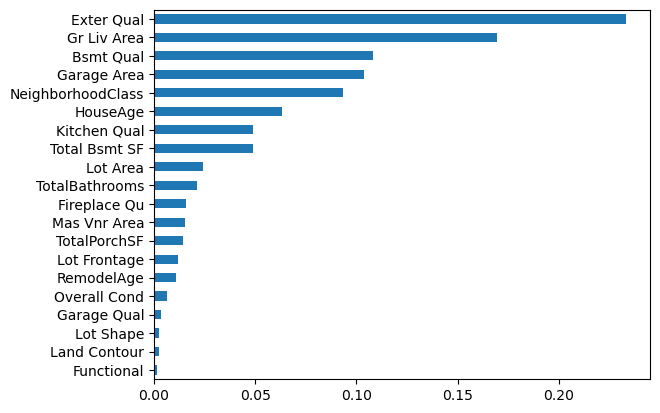

In [8]:
# Ausgabe der feature importance
feat_importances = pd.Series(rf.feature_importances_, index=x_test.columns).sort_values(ascending=False)
_ = feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()


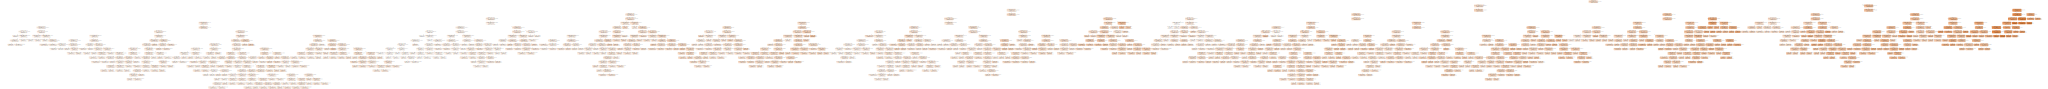

In [9]:
# Ausgabe des ersten Entscheidungsbaums
dot_data = tree.export_graphviz(rf.estimators_[0], 
                  feature_names=x_test.columns.tolist(),  
                  class_names=['SalePrice'],  
                  filled=True, rounded=True,  
                  special_characters=True,
                  rotate=False
                           )
graph = graphviz.Source(dot_data)
graph.render(outfile='Ames_rf_tree0.svg').replace('\\', '/')
graph
